# Objective Functions: A Simple Example with Matrix Factorisation

In [1]:
import pods
d = pods.datasets.movie_body_count()
movies = d['Y']

import pandas as pd
import os

# uncomment the line below if you are doing this task by self study.
pods.util.download_url('https://dl.dropboxusercontent.com/u/4347554/mlai_movies.csv', store_directory = 'class_movie', save_name='movies.csv')
#pods.util.download_url('https://www.dropbox.com/s/s6gqvp9b383b59y/movies.csv?dl=0&raw=1', store_directory = 'class_movie', save_name='movies.csv')
movies = pd.read_csv(os.path.join('class_movie', 'movies.csv'),encoding='latin-1').set_index('index')
movies

user_names = list(set(movies.columns)-set(movies.columns[:9]))
Y = pd.melt(movies.reset_index(), id_vars=['Film', 'index'], 
            var_name='user', value_name='rating', 
            value_vars=user_names)
Y = Y.dropna(axis=0)

import numpy as np
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
U = pd.DataFrame(np.random.normal(size=(len(user_names), q))*0.001, index=user_names)
V = pd.DataFrame(np.random.normal(size=(len(movies.index), q))*0.001, index=movies.index)

Y['rating'] -= Y['rating'].mean()

[==============================]   0.381/0.381MB


### Question 2: Maths and Example Code

Use the chain rule to differentiate the objective function $E(\mathbf{U}, \mathbf{V})$ with respect to $v_{k,\ell}$:
\begin{align}
    \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial v_{k,\ell}}
    &= \frac{\partial}{\partial v_{k,\ell}} \sum_i s_{i,k}(y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k})^2 \\
    &= \sum_i s_{i,k} \Big[\frac{\partial}{\partial v_{k,\ell}}(y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k})^2\Big] \\
    &= \sum_i s_{i,k}\Big[2(y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k}) \frac{\partial}{\partial v_{k,\ell}} (y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k})\Big] \\
    &= -2\sum_i s_{i,k} (y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k}) \Big[\frac{\partial}{\partial v_{k,\ell}}(\mathbf{u}_i^\top\mathbf{v}_{k})\Big]
\end{align}
Because all terms not containing $\mathbf{v}_k$ are zero, $\displaystyle \frac{\partial}{\partial v_{k,\ell}}(\mathbf{u}_i^\top\mathbf{v}_{k}) = u_{i,\ell}$, thus leading to
$$
    \frac{\partial E(\mathbf{U},\mathbf{V})}{\partial v_{k,\ell}} = -2\sum_i s_{i,k} u_{i,\ell} (y_{i,k} - \mathbf{u}_i^\top\mathbf{v}_{k})
$$

In [ ]:
# Question 2 example code

def compute_gV(Y, U, V):
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        gV.loc[film] += 2*diff*U.loc[user]
    return gV

### Question 4: Example Code

Note: the following code monitors the objective function after each time the code runs through the whole data points.

In [2]:
# Question 4 Code Answer: stochastic gradient descent algorithm

def stochastic_descent(obj, Y, U, V, learn_rate):
    Y = Y.iloc[np.random.permutation(len(Y))]  # Shuffle Y
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])  # vTu
        diff = prediction - rating  # vTu - y
        obj += diff**2
        U.loc[user] -= 2*learn_rate*diff*V.loc[film]
        V.loc[film] -= 2*learn_rate*diff*U.loc[user]
    return obj, U, V

In [3]:
# Question 4 Code Answer: the objective function after every 1000 updates

learn_rate = 0.05
iterations = 100
obj = 0.
for i in range(iterations):
    obj, U, V = stochastic_descent(obj, Y, U, V, learn_rate)
    print("Update {}, objective function = {}".format(i, obj))

Update 0, objective function = 481.6878701249441
Update 1, objective function = 481.6875743642115
Update 2, objective function = 481.6869349830282
Update 3, objective function = 481.6851467402605
Update 4, objective function = 481.67966978436743
Update 5, objective function = 481.6619073675807
Update 6, objective function = 481.60031799861144
Update 7, objective function = 481.379512770512
Update 8, objective function = 480.5780236711897
Update 9, objective function = 477.58549040149984
Update 10, objective function = 466.90591159901504
Update 11, objective function = 436.1836229070845
Update 12, objective function = 382.1555679719786
Update 13, objective function = 346.7467804734154
Update 14, objective function = 319.0194558791257
Update 15, objective function = 280.967598422663
Update 16, objective function = 241.23440127448163
Update 17, objective function = 201.524135502881
Update 18, objective function = 168.02391027051172
Update 19, objective function = 137.91628505821902
Update

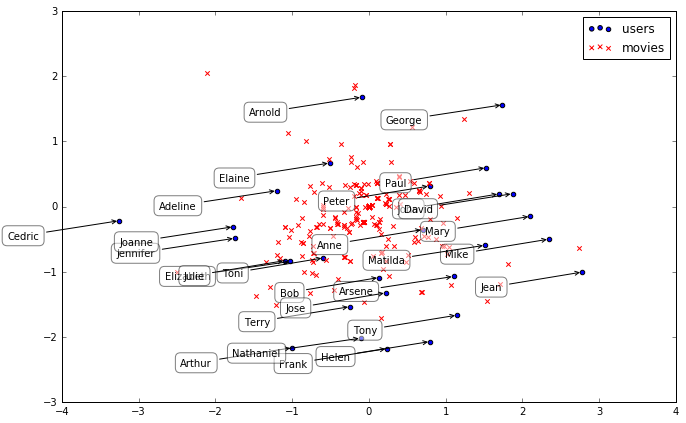

In [4]:
# Question 4 Code Answer: the movie map and the user map in two dimensions

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 7))
plt.scatter(U[0], U[1], label='users')
plt.scatter(V[0], V[1], c='r', marker='x', label='movies')
for label, x, y in zip(U.index, U[0], U[1]):
    plt.annotate(label, 
                 xy = (x, y), xytext = (-80, -20),
                 textcoords = 'offset points', ha = 'right', va = 'bottom',
                 bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
                 arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
                )
plt.legend()
plt.show()

### Question 5: Example Code

Note: each iteration may require many minutes to complete.

In [5]:
import pods
d = pods.datasets.movielens100k()
Y=d['Y']

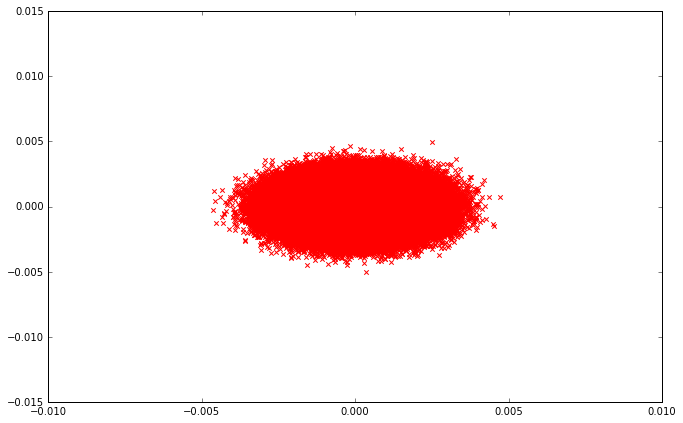

Update 0, objective function = 880853.1645960902, computation time = 19.861496170361836 minutes


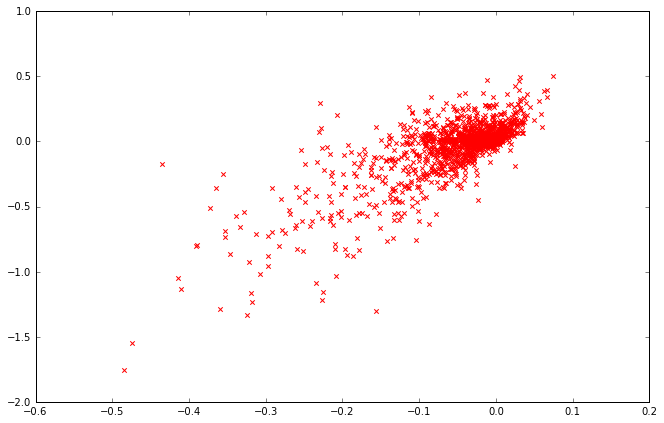

Update 1, objective function = 641392.4745038913, computation time = 19.12280604839325 minutes


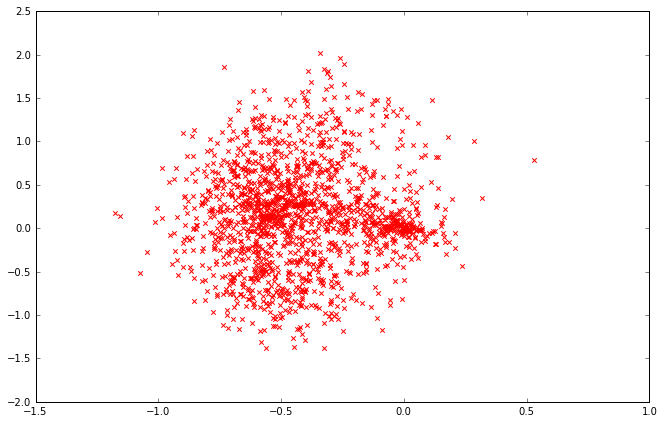

Update 2, objective function = 569444.1716784859, computation time = 19.22221260468165 minutes


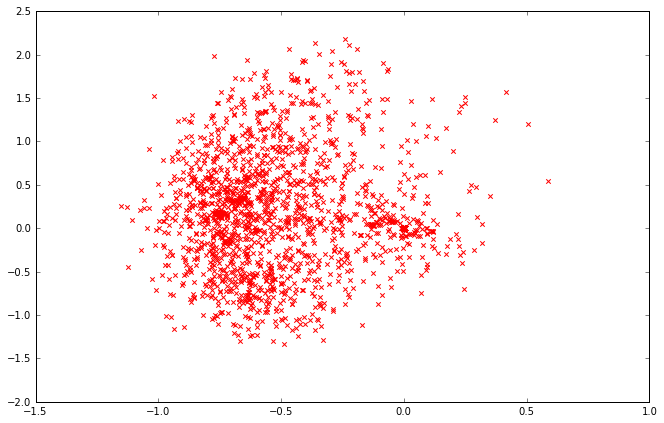

Update 3, objective function = 562958.741468031, computation time = 19.318928507963815 minutes


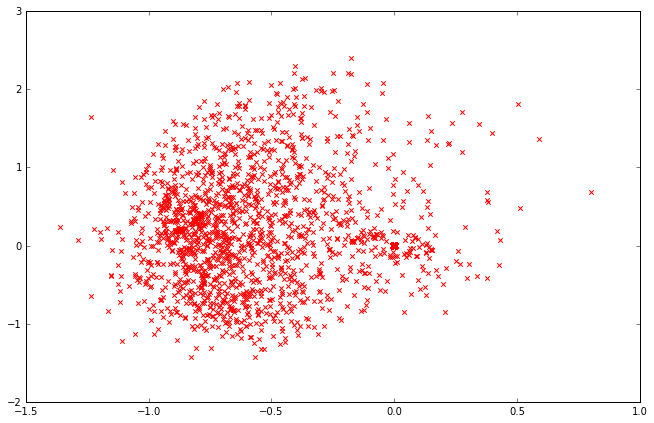

Update 4, objective function = 560787.5523465665, computation time = 19.35965129137039 minutes


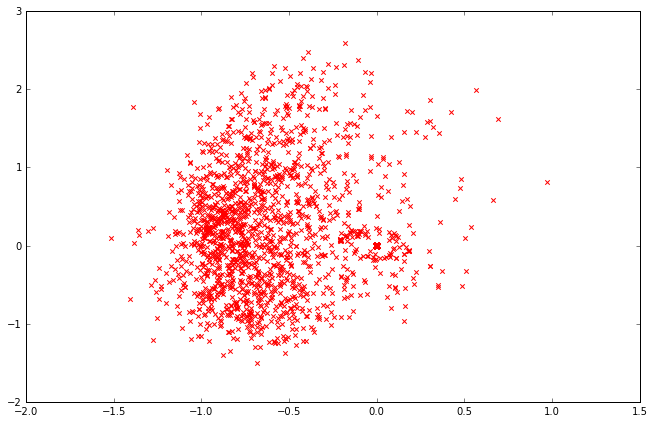

Update 5, objective function = 559938.9969144976, computation time = 19.742648533980052 minutes


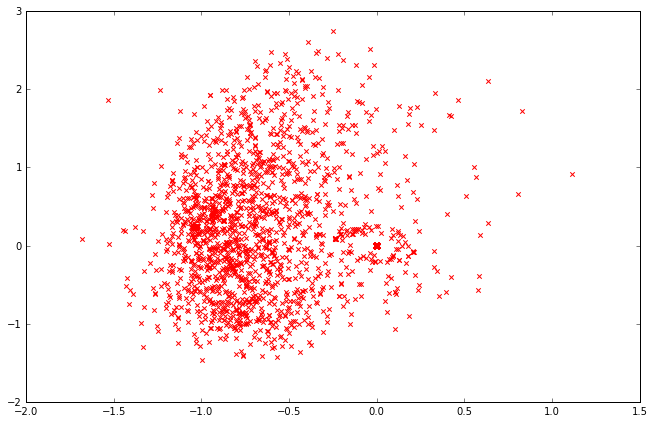

Update 6, objective function = 559590.5366104059, computation time = 20.091604367891946 minutes


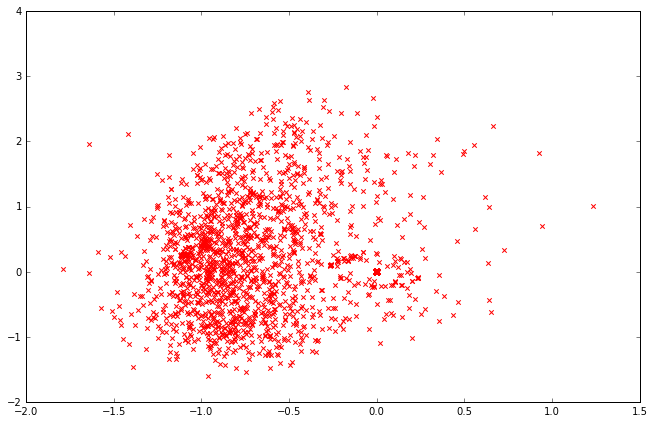

Update 7, objective function = 559514.3244207135, computation time = 19.399725369612376 minutes


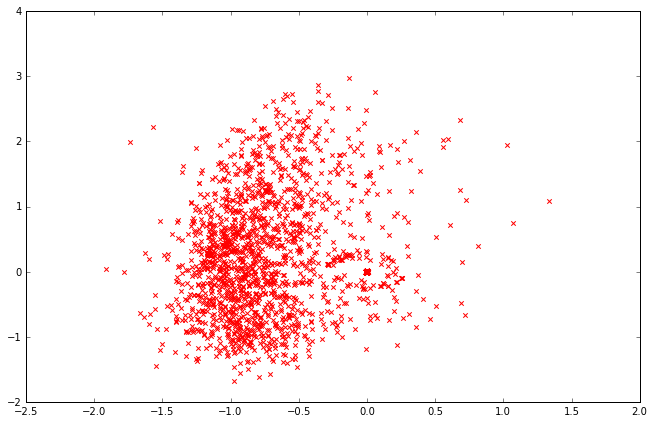

Update 8, objective function = 559721.5429407194, computation time = 19.856441315015157 minutes


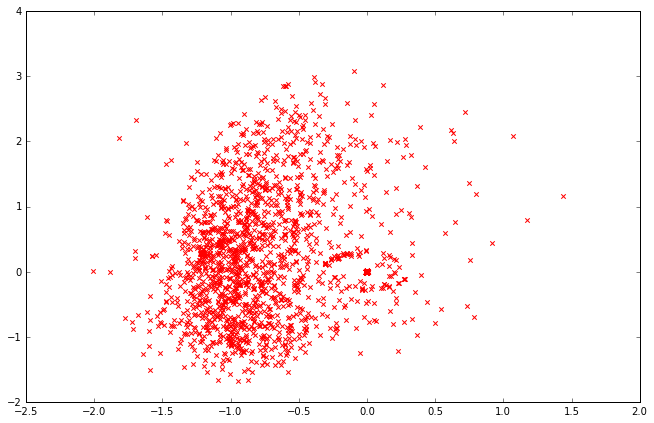

Update 9, objective function = 560028.2819986719, computation time = 19.456729475657145 minutes


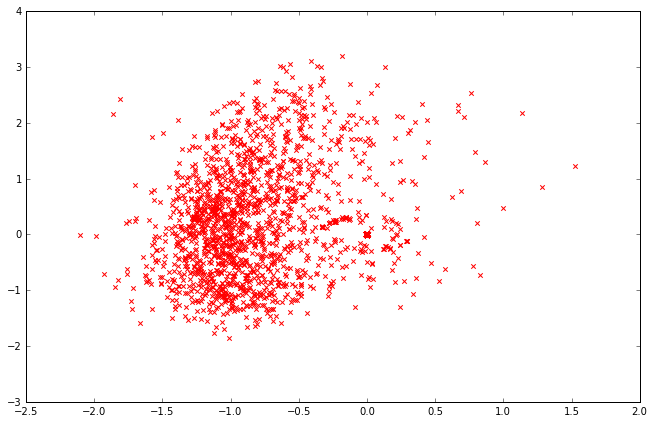

In [6]:
# Question 5 Code Answer

%matplotlib inline
import matplotlib.pyplot as plt
import time

def sgd(obj, Y, U, V, learn_rate):  # Stochastic gradient descent for movielens100k
    Y = Y.iloc[np.random.permutation(len(Y))]  # Shuffle Y
    obj = 0.
    for ind, series in Y.iterrows():
        item = series['item']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[item])  # vTu
        diff = prediction - rating  # vTu - y
        obj += diff**2
        U.loc[user] -= 2*learn_rate*diff*V.loc[item]
        V.loc[item] -= 2*learn_rate*diff*U.loc[user]
    return obj, U, V

Y = Y.reset_index()
Y['rating'] -= Y['rating'].mean()
q = 2
U = pd.DataFrame(np.random.normal(size=(len(Y.user.unique()), q))*0.001, index = Y.user.unique())
V = pd.DataFrame(np.random.normal(size=(len(Y.index), q))*0.001, index=Y.index)

# initial plot
plt.figure(figsize=(11, 7))
plt.scatter(V[0], V[1], c='r', marker='x')
plt.show()
    
learn_rate = 0.008
iterations = 10
obj = 0.
for i in range(iterations):
    t0 = time.time()
    obj, U, V = sgd(obj, Y, U, V, learn_rate)
    t1 = time.time()
    print("Update {}, objective function = {}, computation time = {} minutes".format(i, obj, (t1 - t0)/60.))

    # plot at each iteration
    plt.figure(figsize=(11, 7))
    plt.scatter(V[0], V[1], c='r', marker='x')
    plt.show()